## Тестовое задание "АВ Софт" на должность  Junior Machine Learning Engineer
Выполнил: Новиков Николай

### Условие задания
− Необходимо реализовать модель на основе данного датасета  
− Для достижения данной цели нужно обработать датасет, привести его в вид, готовый для обучения с помощью модели МЛ (выбор модели зависит только от вас, ограничений на это
нет)  

Требования:  
− Python script/ Python Jupyter notebook  

Материалы:  
− Ссылка на датасет:   
https://drive.google.com/file/d/1lL9XWBR_3F4xozizi0aOEfrI-VqqNcKw/view?usp=sharing  
Описание датасета:  
− Датасет описывает некоторую зависимость числа bugs от значений repository_name, commit_hash, commit_date, commit_author, commit_message. Вам необходимо выявить данную зависимость и написать скрипт/ноутбук, обучающий модель по данному датасету  
  
Готовый проект выложить на GitHub и прислать ссылку

### Сведения о среде  
 - Google Colaboratory и Kaggle Notebook. Выбор облачной платформы обоснован возможностью работы на GPU (необходим для работы с текстовыми признаками средствами библиотеки CatBoost).

### 1. Предварительный анализ и предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/avsoft-test-dataset/train.csv')

In [3]:
# Просмотр таблицы
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repository_name  319 non-null    object
 1   commit_hash      319 non-null    object
 2   commit_date      319 non-null    object
 3   commit_author    319 non-null    object
 4   commit_message   319 non-null    object
 5   bugs             319 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 15.1+ KB
None


,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
5,mlm,4f5f3743,2020-06-11T09:12:37,Peggy,Добавлено больше логирования и фикс до частичн...,6
6,mlm,24a11c40,2020-06-10T15:34:22,Victor,"Отладка, чтоб оно хотябы запускалось",4
7,mlm,3287c74a,2020-06-10T15:34:04,Victor,Добавил скрипт для запуска контейнера,4
8,mlm,c78d5187,2020-06-10T15:22:21,Victor,label не нужен,2
9,mlm,bcb47e60,2020-06-10T14:54:14,Victor,Установка всех зависимостей теперь в докер файле,5


In [4]:
# Счетчики значений для каждого столбца
for column in df:
    print(column)
    print(df[column].value_counts())
    print()

repository_name
conductor    114
sensor       102
mlm           41
standard      29
dockers       19
agent         14
Name: repository_name, dtype: int64

commit_hash
ea2c04d4    1
92aa277c    1
f946e945    1
5dbea449    1
f70f35c5    1
           ..
510b9895    1
e748af51    1
8733e39c    1
d6826da7    1
dea39c26    1
Name: commit_hash, Length: 319, dtype: int64

commit_date
2020-06-10T10:17:03    2
2020-06-12T14:26:12    1
2020-03-23T14:54:47    1
2020-04-22T19:07:30    1
2020-06-10T14:32:09    1
                      ..
2020-05-01T11:16:37    1
2020-05-14T15:06:39    1
2020-03-15T17:02:12    1
2020-05-21T15:47:32    1
2020-05-13T16:35:53    1
Name: commit_date, Length: 318, dtype: int64

commit_author
Victor     134
Mallory     67
Wendy       48
Dabe        42
Trudy        9
Eve          9
Carol        4
Peggy        2
Bob          2
Alice        2
Name: commit_author, dtype: int64

commit_message
Merge branch 'changes-to-merge' into 'master'                                    4
Ini

Датасет описывает работу нескольких авторов с несколькими репозиториями. Столбцы следует привести к соответствующим форматам. Столбец с хэшем коммита неинформативен (уникален для каждого объекта, алгоритм хеширования не должен позволять извлечь какие-либо данные об объекте по его хешу) - его удаляем.

In [5]:
df.drop(columns='commit_hash', inplace=True)
df['commit_date'] = pd.to_datetime(df['commit_date'])
df['bugs'] = pd.to_numeric(df['bugs'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   repository_name  319 non-null    object        
 1   commit_date      319 non-null    datetime64[ns]
 2   commit_author    319 non-null    object        
 3   commit_message   319 non-null    object        
 4   bugs             319 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 12.6+ KB


repository_name


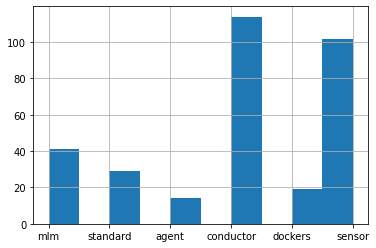


commit_date


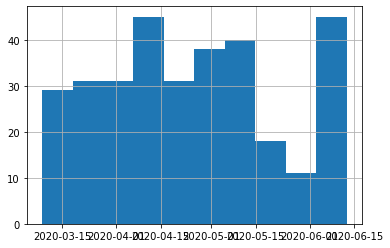


commit_author


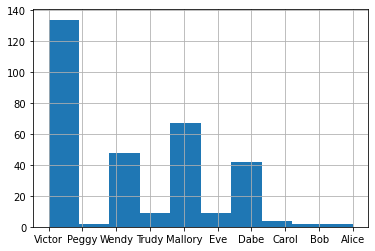


bugs


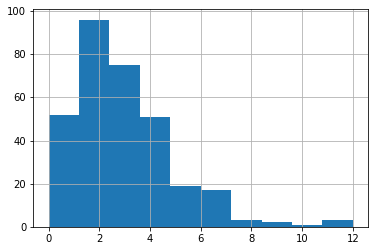

In [6]:
# Просмотр распределения признаков
for column in df.drop(columns='commit_message'):
    print(column)
    df[column].hist()
    plt.show()
    print()

Просмтрим гистограммы распределения и диаграммы размаха целевого признака при группировке по авторам и по репозиториям:

In [7]:
# Всполмогательный датасет для нанесения слоя с общим распределением
df_total = df[['repository_name', 'commit_author', 'bugs']].copy()
df_total[['repository_name', 'commit_author']] = 'Total'
df_total.head()

,repository_name,commit_author,bugs
0,Total,Total,4
1,Total,Total,3
2,Total,Total,4
3,Total,Total,3
4,Total,Total,7


Группировка по repository_name

К-во записей для каждого значения:
conductor    114
sensor       102
mlm           41
standard      29
dockers       19
agent         14
Name: repository_name, dtype: int64


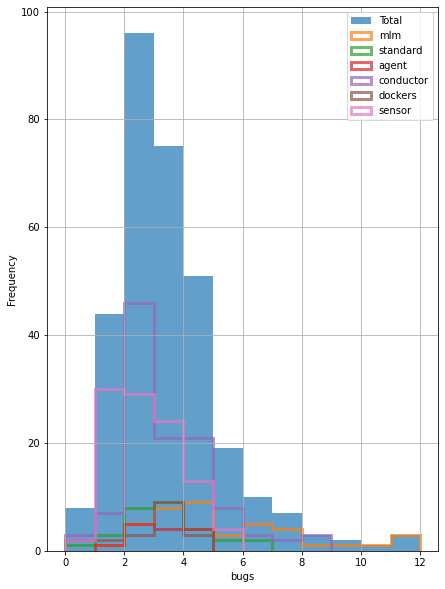

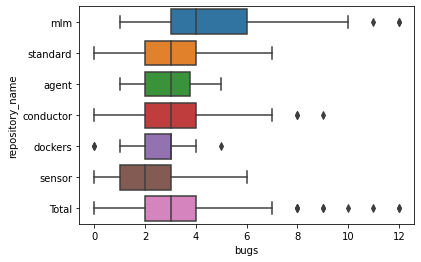




Группировка по commit_author

К-во записей для каждого значения:
Victor     134
Mallory     67
Wendy       48
Dabe        42
Trudy        9
Eve          9
Carol        4
Peggy        2
Bob          2
Alice        2
Name: commit_author, dtype: int64


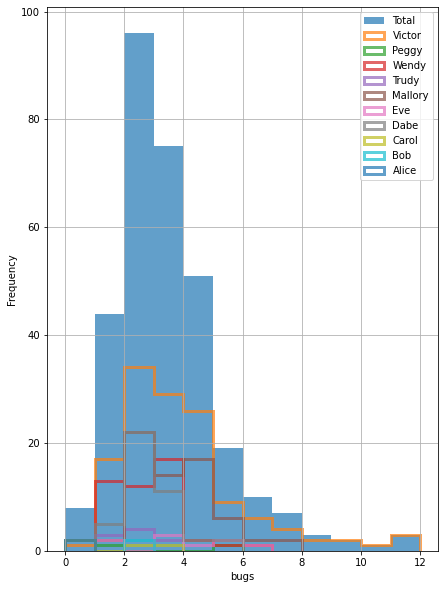

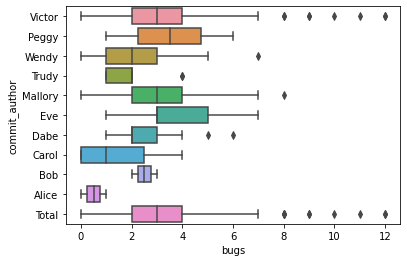

In [8]:
for column in ['repository_name', 'commit_author']:
    ax = df.plot(kind='hist', y='bugs', bins=12,
             linewidth=3, alpha=0.7, label='Total')
    print('Группировка по', column)
    print()
    print('К-во записей для каждого значения:')
    print(df[column].value_counts())
    for value in df[column].unique():
        # Подбираем оптимально к-во "корзин" для каждого признака
        bins = df[df[column] == value]['bugs'].max() - \
               df[df[column] == value]['bugs'].min()
        df[df[column] == value].plot(kind='hist', y='bugs', 
                                     histtype='step', bins=bins,
                                     linewidth=3, alpha=0.7,
                                     label=value, figsize=(7,10), 
                                     grid=True, ax=ax)
    ax.set_xlabel('bugs')
    plt.show()
    sns.boxplot(y=column, x="bugs", data=pd.concat([df, df_total]), 
                orient="h")
    plt.show()
    print('\n\n')

In [9]:
# К-во записей в каждом репозитории каждым автором
df.groupby(['repository_name', 
            'commit_author'])['commit_message'].count()

repository_name  commit_author
agent            Victor           14
conductor        Dabe             35
                 Eve               3
                 Mallory          36
                 Trudy             6
                 Victor           18
                 Wendy            16
dockers          Bob               2
                 Carol             4
                 Mallory           3
                 Victor            3
                 Wendy             7
mlm              Peggy             2
                 Victor           39
sensor           Alice             2
                 Dabe              7
                 Eve               6
                 Mallory          28
                 Trudy             3
                 Victor           47
                 Wendy             9
standard         Victor           13
                 Wendy            16
Name: commit_message, dtype: int64

In [10]:
# К-во записей каждым автором в каждом репозитории
df.groupby(['commit_author', 
            'repository_name'])['commit_message'].count()

commit_author  repository_name
Alice          sensor              2
Bob            dockers             2
Carol          dockers             4
Dabe           conductor          35
               sensor              7
Eve            conductor           3
               sensor              6
Mallory        conductor          36
               dockers             3
               sensor             28
Peggy          mlm                 2
Trudy          conductor           6
               sensor              3
Victor         agent              14
               conductor          18
               dockers             3
               mlm                39
               sensor             47
               standard           13
Wendy          conductor          16
               dockers             7
               sensor              9
               standard           16
Name: commit_message, dtype: int64

**Анализ верменного ряда**

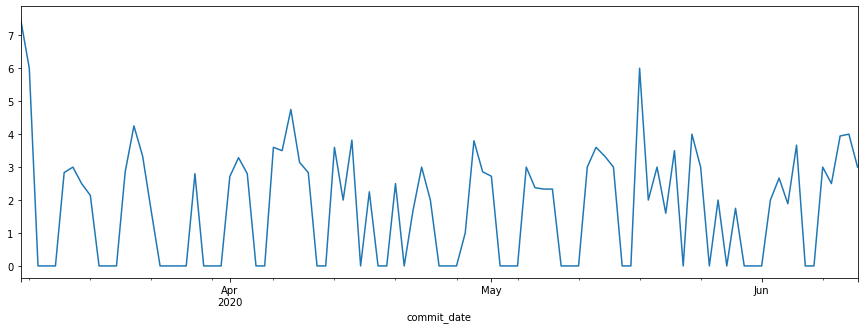

In [11]:
# Среднее к-во багов в коммите по дням (если за день коммитов не было, то значение обнуляется)
df.set_index('commit_date')['bugs'].resample('1D').mean().fillna(0).plot(figsize=(15, 5));

In [12]:
# Просмотр декомпозиции ряда на тренд, сезонность и остаток
def decomp(df):
    decomposed = seasonal_decompose(df)
    plt.figure(figsize=(10, 10))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residual')
    plt.tight_layout()

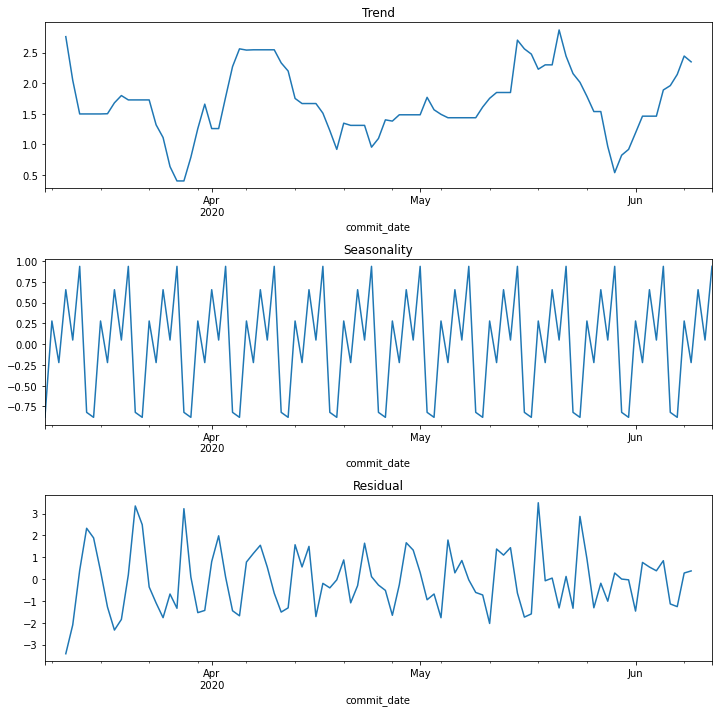

In [13]:
# Усреднение ежедневной статистики
decomp(df.set_index('commit_date')['bugs'].resample('1D').mean().fillna(0))

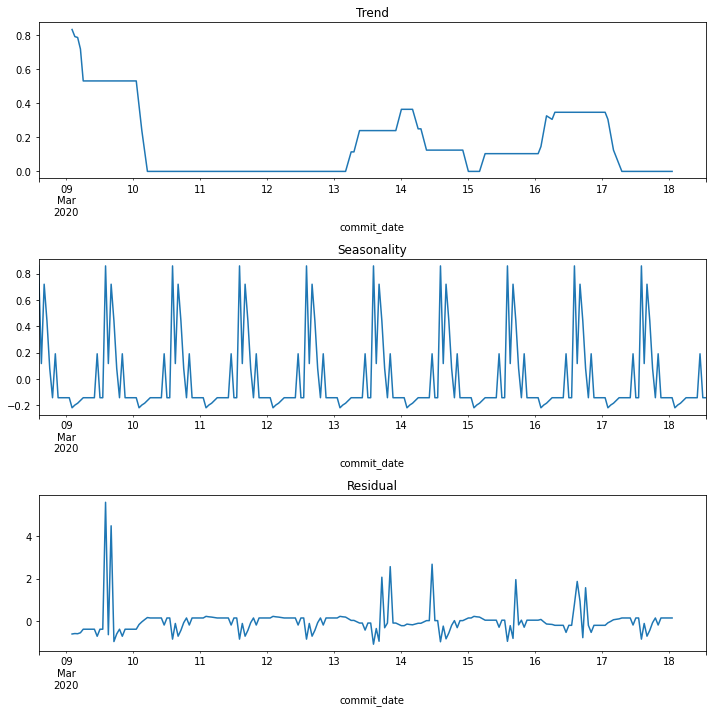

In [14]:
# Усреднение статистики за час (для наглядности, выведем на печать первые 10 дней)
decomp(df.set_index('commit_date')['bugs'].resample('1H').mean().fillna(0).iloc[:240])

Декомпозиция временного ряда демонтсрирует явное наличие сезонности - зависимости целевого признака от часа суток и от дня недели. Добавим в датаест соответствующие признаки:

In [15]:
df['hour'] = df['commit_date'].apply(lambda timestamp: timestamp.hour)
df['dayofweek'] = df['commit_date'].apply(lambda timestamp: timestamp.dayofweek)
df.head()

,repository_name,commit_date,commit_author,commit_message,bugs,hour,dayofweek
0,mlm,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4,14,4
1,mlm,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,11,4
2,mlm,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,15,3
3,mlm,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3,10,3
4,mlm,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7,9,3


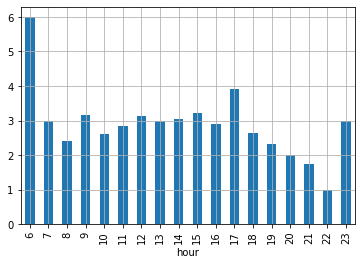

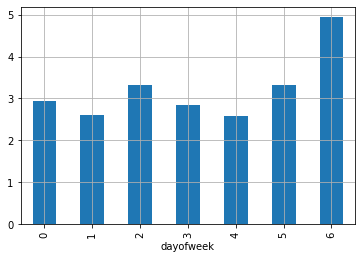

In [16]:
# Среднее к-во багов на коммит в зависимости от часа суток и дня недели
df.groupby('hour')['bugs'].mean().plot(kind='bar', grid=True)
plt.show()
df.groupby('dayofweek')['bugs'].mean().plot(kind='bar', grid=True);

Багов очевидно больше ранним утром и в конце недели.

In [17]:
# К-во коммитов у каждого автора
df['commit_author'].value_counts()

Victor     134
Mallory     67
Wendy       48
Dabe        42
Trudy        9
Eve          9
Carol        4
Peggy        2
Bob          2
Alice        2
Name: commit_author, dtype: int64

Имя автора со слишком маленьким числом коммитов является плохим признаком для обучения. Объеденим авторов, не вошедших в топ-4 в одну категорию ('other'):

In [18]:
top_authors = df['commit_author'].value_counts().head(4).index

df['commit_author'] = df['commit_author'].apply(
    lambda name: name if name in top_authors else 'other')
df['commit_author'].value_counts()

Victor     134
Mallory     67
Wendy       48
Dabe        42
other       28
Name: commit_author, dtype: int64

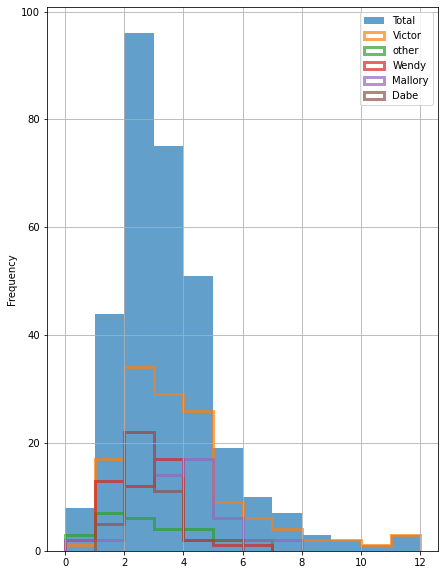

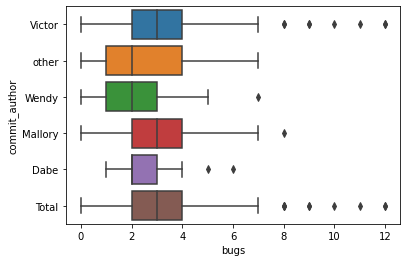

In [19]:
# Взглянем еще раз на распределения с учетом объекдинения авторов
ax = df.plot(kind='hist', y='bugs', bins=12,
         linewidth=3, alpha=0.7, label='Total')
for value in df['commit_author'].unique():
    bins = df[df['commit_author'] == value]['bugs'].max() - \
           df[df['commit_author'] == value]['bugs'].min()
    df[df['commit_author'] == value].plot(kind='hist', y='bugs', 
                                 histtype='step', bins=bins,
                                 linewidth=3, alpha=0.7,
                                 label=value, figsize=(7,10), 
                                 grid=True, ax=ax)
plt.show()
sns.boxplot(y='commit_author', x="bugs", data=pd.concat([df, df_total]), 
            orient="h")
plt.show()
print()

In [20]:
# Столбец с датой больше не нужен
df.drop(columns='commit_date', inplace=True)
df.head()

,repository_name,commit_author,commit_message,bugs,hour,dayofweek
0,mlm,Victor,объяснения предсказаний с помощью lime,4,14,4
1,mlm,Victor,Поставил lime вместо eli5,3,11,4
2,mlm,Victor,Скрипт для создния пакетов обновления,4,15,3
3,mlm,Victor,Сортировка весов по убыванию,3,10,3
4,mlm,Victor,не надо конвертировать массив до операции по с...,7,9,3


**Вывод:** Проведен анализ данных, выделены обучающие признаки: название репозитория, автор коммита, сообщение, час и день недели. Текстовый признак сохранен для классификатора CatBoost.


### 2. Обучение модели  
#### 2.1. Выбор модели и обучающих признаков
Целевой признак (предсказываемая величина) представляет собой целое число в диапазоне от 0 до 12. Таким образом, поставленную задачу можно рассматривать как задачу мультиклассовой классификации с 12-ю классами. Но, учитывая, что целевой признак также является количественной величиной (число багов), для оценки качества модели лучше подойдет метрика регрессии, наглядно демонстрирующая отклонение предсказания от таргета в еденицах измерения целевого признака. Поэтому, в качестве целевой метрики принимаем среднюю абсолютную ошибку МАЕ.  
Также, учитывая количественный характер целевого признака, для предсказания можно применить модели регрессии, с округлением их предсказания до ближайшего целого.  
Таким образом, для предсказания будут опробованы следующие модели:  
 - линейная регрессия библиотеки Sklearn **LinearRegression**;  
 - логистическая регрессия библиотеки Sklearn **LogisticRegression**;  
 - градиентный бустинг CatBoost, модель регрессии **CatBoostRegressor**;
 - классификатор CatBoost **CatBoostClassifier**.  

Выбор библиотеки градиентного бустинга связан с возможностью автоматической обработки текстовых признаков (но только для модели классификации), а также хорошим качеством предсказания с дефолтными гиперпараметрами. 

In [21]:
# Разделяем целевой и обучающие признаки и отделяем тестовую выборку
X = df.drop(columns='bugs')
y = df['bugs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)

(255, 5)
(64, 5)


In [22]:
np.sort(y_test.unique())  # Значения целевого признака в тестовой выборке

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

В тестовую выборку не вошли объекты со значением целевого признака более 8. Таких объектов в исходном датасете недостаточно для нормального обучения модели - считаем их выбросами и удаляем из обучающей выборки:

In [23]:
X_train.drop(index=y_train[y_train > 8].index, inplace=True)
y_train = y_train[y_train <= 8]
print(X_train.shape)
print(y_train.shape)

(249, 5)
(249,)


Размер обучающей выборки уменьшился на 6 объектов - не так много.

Учитывая малый объем выборки, для тюнинга гиперпараметров целесообразно пользоваться кросс-валидацией. Поскольку используется нестандартная целевая метрика, воспользоваться библиотечными методами для кросс-валидации не удастся. Напишем свою функцию.

In [24]:
# Вспомогательные функции

'''Разбиение обучающей выборки на подвыборки для кросс-валидации, 
n_splits - к-во фолдов.

Схема процесса:
______________________________
|f(n)|f(n-1)|...|f(2)   |f(1)|  -  фолды
| 1/2| 1/2  |   |1/(n-1)|1/n |  -  test_size (доля фолда от остатка)
|<--r(n-2)->|           |    |  -  последний остаток делится пополам на 2 последних фолда
|<---------r(1)-------->|    |  -  первый остаток, после отделения первого фолда
|<------------r(0)---------->|  -  изначально вся выборка в остатке
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Функция возвращает два словаря с номерами фолдов в качестве ключей и 
соответствующими подвыборками обучающих и целевых признаков в значениях
'''
def my_cv(X, y, n_splits, random_state):
    X_fold = {}  # Множество подвыборок обучающих признаков
    y_fold = {}  # Множество подвыборок целевых признаков
    X_rest = {}  # Остатки, не вошедшие (пока что) в фолды
    y_rest = {}  # --//--
    X_rest[0] = X  # В начале у нас нет фолдов, значит всё множество в остатке
    y_rest[0] = y
    for i in range(n_splits-1):
        X_rest[i+1], X_fold[i+1], y_rest[i+1], y_fold[i+1] = train_test_split(
            X_rest[i], y_rest[i], test_size=1/(n_splits-i), random_state=random_state)

    X_fold[n_splits] = X_rest[n_splits-1]
    y_fold[n_splits] = y_rest[n_splits-1]

    return X_fold, y_fold


# Кросс валидация модели логистической регрессии
def lr_cv(X, y, n_splits):
    X_fold, y_fold = my_cv(X, y, n_splits, random_state=43)
    lr_mae = []  # Список результирующих метрик 

    for i in range(1, n_splits+1):
        test_index = X_fold[i].index
        train_index = X.drop(index=test_index).index
        lr_model = LogisticRegression().fit(X.loc[train_index], y.loc[train_index])
        lr_mae.append(mean_absolute_error(y.loc[test_index], 
                                          lr_model.predict(X.loc[test_index])))
    
    return np.array(lr_mae)


# Кросс валидация модели линейной регрессии
def linreg_cv(X, y, n_splits):
    X_fold, y_fold = my_cv(X, y, n_splits, random_state=43)
    linreg_mae = []  # Список результирующих метрик

    for i in range(1, n_splits+1):
        test_index = X_fold[i].index
        train_index = X.drop(index=test_index).index
        linreg_model = LinearRegression().fit(X.loc[train_index], y.loc[train_index])
        linreg_mae.append(mean_absolute_error(
            y.loc[test_index], 
            linreg_model.predict(X.loc[test_index]).round())
        )
    
    return np.array(linreg_mae)


# Кросс валидация для модели CatBoostRegressor
def catreg_cv(X, y, n_splits, cat_features, random_state=43, 
              catboost_params={}):
    X_fold, y_fold = my_cv(X, y, n_splits, random_state)
    cat_mae = []  # Список результирующих метрик

    for i in range(1, n_splits+1):
        test_index = X_fold[i].index
        train_index = X.drop(index=test_index).index

        model = CatBoostRegressor(
            loss_function='MAE', verbose=False
            ).fit(X.loc[train_index], y.loc[train_index], cat_features=cat_features)
        split_mae = mean_absolute_error(
            y.loc[test_index],
            model.predict(X.loc[test_index]).round()
            )
        cat_mae.append(split_mae)

    return np.array(cat_mae)


# Кросс валидация для модели CatBoostClassifier
def cat_cv(X, y, n_splits, cat_features, text_features, random_state=43, 
           catboost_params={}):
    X_fold, y_fold = my_cv(X, y, n_splits, random_state)

    catboost_default_params = {
      'iterations': 1000,
      'learning_rate': 0.03,
      'eval_metric': 'Accuracy',
      'task_type': 'GPU'
    }
    catboost_default_params.update(catboost_params)

    cat_mae = []  # Список результирующих метрик

    for i in range(1, n_splits+1):
        test_index = X_fold[i].index
        train_index = X.drop(index=test_index).index

        learn_pool = Pool(
            X.loc[train_index], 
            y.loc[train_index], 
            cat_features=cat_features,
            text_features=text_features,
            feature_names=list(X)
        )
        test_pool = Pool(
            X.loc[test_index], 
            cat_features=cat_features,
            text_features=text_features,
            feature_names=list(X)
        )

        model = CatBoostClassifier(**catboost_default_params)
        model.fit(learn_pool, verbose=False)

        split_mae =  mean_absolute_error(y.loc[test_index], 
                                         model.predict(test_pool))
        cat_mae.append(split_mae)

    return np.array(cat_mae)


# Представление результатов кросс-валидации в формате "среднее ± ст.отклонение"
def cv_result(scores):
    return '{:.3f} ± {:.3f}'.format(scores.mean(), scores.std()) 

In [25]:
# Подготовка обучающих признаков

text_features = ['commit_message']  # Столбец текстовых признаков

# Порядковое кодирование признаков 'repository_name' и 'commit_author'
X_ordinal = X.copy()  # Результат запишем в отдельный датасет
for column in 'repository_name', 'commit_author':
    X_ordinal[column] = \
    OrdinalEncoder().fit_transform(pd.DataFrame(X_ordinal[column]))

# Обучающая и тестовая подвыборки без текстовых признаков
X_train_no_text = X_train.drop(text_features, axis=1)
X_test_no_text = X_test.drop(text_features, axis=1)

# Обучающая и тестовая подвыборки с порядковым кодирвоанием признаков 
# 'repository_name' и 'commit_author', с и без текстовых признаков
X_ordinal_train = X_ordinal.loc[y_train.index]
X_ordinal_test = X_ordinal.loc[y_test.index]
X_ordinal_train_no_text = X_ordinal_train.drop(text_features, axis=1)
X_ordinal_test_no_text = X_ordinal_test.drop(text_features, axis=1)

**Подбор числа фолдов для кросс-валидации.** Для фиксированного значения n_splits проведем кросс валидации различных моделей (для ускорения процесса исключим классификатор CatBoost - он  работает существенно дольше остальных моделей) и измерим среднее значение стандартных отклонений метрик. Таким образом, выберем к-во фолдов, дающее наименьший разброс в значениях метрики при кросс-валидации:

In [26]:
%%time

stds = pd.Series(name='MAE std.')  # Сюда будем записывать средние отклонения

for n_splits in range(3, 11):  # Проведем тест на числе фолдов от 3 до 10
    print('n_splits =', n_splits)  # Выведем на экран динамику процесса

    # Датасет для записи результатов кросс-валидации
    # 'features' - описание предобработки признаков, 
    # 'model' - модель, 
    # 'mae' - среднее значение метрики, 
    # 'std' - стандартное отклонение для результатов кросс-валидации
    test_report = pd.DataFrame(columns=['features', 'model', 'mae', 'std'])
    i = 0  # Индекс датасета (порядковый номер эксперимента)

    # Переберем возможные варианты признаков, передаваемых моделям CatBoost
    # как категориальные
    for cat_features in (
        ['repository_name', 'commit_author'], 
        ['repository_name', 'commit_author', 'hour'], 
        ['repository_name', 'commit_author', 'dayofweek'], 
        ['repository_name', 'commit_author', 'hour', 'dayofweek']
    ):
        # Для нагладности, выводим на экран динамику процесса
        print('CatBoost categorical features:', cat_features)
        print()

        # Кросс-валидация модели CatBoostRegressor
        catreg_scores = catreg_cv(X=X_train_no_text,
                                  y=y_train,
                                  n_splits=n_splits,
                                  cat_features=cat_features)
        print('CatBoost regression MAE: {}'
              .format(cv_result(catreg_scores)))

        # Заносим результаты кросс-валидации в датасет
        i += 1
        features = 'CatBoost categorical features: {}'.format(cat_features)
        model = 'CatBoostRegressor'
        mae = catreg_scores.mean()
        std = catreg_scores.std()
        test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
        features, model, mae, std

        # Прямое кодирование категориальных признаков
        X_ohe = pd.get_dummies(X_train.drop(text_features, axis=1),
                               columns=cat_features, drop_first=True)

        # Кросс-валидация модели логистической регрессии
        lr_scores = lr_cv(X_ohe, y_train, n_splits)
        print('LogisticRegression MAE with one-hot encoding: ', 
              cv_result(lr_scores))

        # Заносим результаты кросс-валидации в датасет
        i += 1
        features = 'OHE: {}'.format(cat_features)
        model = 'LogisticRegression'
        mae = lr_scores.mean()
        std = lr_scores.std()
        test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
        features, model, mae, std

        # Кросс-валидация модели линейной регрессии
        linreg_scores = linreg_cv(X_ohe, y_train, n_splits)
        print('LinearRegression MAE with one-hot encoding: ', 
              cv_result(linreg_scores))

        # Заносим результаты кросс-валидации в датасет
        i += 1
        model = 'LinearRegression'
        mae = linreg_scores.mean()
        std = linreg_scores.std()
        test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
        features, model, mae, std

        # Прямое кодирование категориальных признаков для выборки с порядковым 
        # кодированием признаков 'repository_name' и 'commit_author'
        X_ordinal_ohe = pd.get_dummies(X_ordinal_train.drop(text_features, axis=1),
                                       columns=cat_features[2:], drop_first=True)

        # Кросс-валидация модели логистической регрессии
        lr_scores = lr_cv(X_ordinal_ohe, y_train, n_splits)
        print('LogisticRegression MAE with one-hot and ordinal encoding: ', 
              cv_result(lr_scores))

        # Заносим результаты кросс-валидации в датасет
        i += 1
        features = 'Ordinal enc: {}. OHE: {}'.format(cat_features[:2], 
                                                     cat_features[2:])
        model = 'LogisticRegression'
        mae = lr_scores.mean()
        std = lr_scores.std()
        test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
        features, model, mae, std

        # Кросс-валидация модели линейной регрессии
        linreg_scores = linreg_cv(X_ordinal_ohe, y_train, n_splits)
        print('LinearRegression MAE with one-hot and ordinal encoding: ', 
              cv_result(linreg_scores))
        print()

        # Заносим результаты кросс-валидации в датасет
        i += 1
        model = 'LinearRegression'
        mae = linreg_scores.mean()
        std = linreg_scores.std()
        test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
        features, model, mae, std

        print()

        # Сохраняем среднее значение отлонений для данного числа фолдов
        stds.loc[n_splits] = test_report['std'].mean()

n_splits = 3
CatBoost categorical features: ['repository_name', 'commit_author']

CatBoost regression MAE: 1.185 ± 0.080
LogisticRegression MAE with one-hot encoding:  1.249 ± 0.071
LinearRegression MAE with one-hot encoding:  1.185 ± 0.063
LogisticRegression MAE with one-hot and ordinal encoding:  1.325 ± 0.110
LinearRegression MAE with one-hot and ordinal encoding:  1.161 ± 0.015


CatBoost categorical features: ['repository_name', 'commit_author', 'hour']

CatBoost regression MAE: 1.261 ± 0.063
LogisticRegression MAE with one-hot encoding:  1.245 ± 0.066
LinearRegression MAE with one-hot encoding:  1.221 ± 0.059
LogisticRegression MAE with one-hot and ordinal encoding:  1.349 ± 0.061
LinearRegression MAE with one-hot and ordinal encoding:  1.265 ± 0.098


CatBoost categorical features: ['repository_name', 'commit_author', 'dayofweek']

CatBoost regression MAE: 1.173 ± 0.025
LogisticRegression MAE with one-hot encoding:  1.221 ± 0.050
LinearRegression MAE with one-hot encoding:  1.14

CatBoost regression MAE: 1.156 ± 0.181
LogisticRegression MAE with one-hot encoding:  1.213 ± 0.173
LinearRegression MAE with one-hot encoding:  1.213 ± 0.146
LogisticRegression MAE with one-hot and ordinal encoding:  1.321 ± 0.174
LinearRegression MAE with one-hot and ordinal encoding:  1.280 ± 0.195


CatBoost categorical features: ['repository_name', 'commit_author', 'dayofweek']

CatBoost regression MAE: 1.156 ± 0.170
LogisticRegression MAE with one-hot encoding:  1.265 ± 0.148
LinearRegression MAE with one-hot encoding:  1.160 ± 0.185
LogisticRegression MAE with one-hot and ordinal encoding:  1.289 ± 0.175
LinearRegression MAE with one-hot and ordinal encoding:  1.204 ± 0.237


CatBoost categorical features: ['repository_name', 'commit_author', 'hour', 'dayofweek']

CatBoost regression MAE: 1.092 ± 0.143
LogisticRegression MAE with one-hot encoding:  1.233 ± 0.176
LinearRegression MAE with one-hot encoding:  1.188 ± 0.154
LogisticRegression MAE with one-hot and ordinal encoding:  

In [27]:
stds.sort_values()  # Число фолдов и стандартные отклонения при кросс-валидации

3     0.058045
5     0.084993
6     0.101131
4     0.144458
8     0.176178
10    0.176745
7     0.215023
9     0.236535
Name: MAE std., dtype: float64

Для дальнейшей работы принимаем числофолдов кросс-валидации **n_splits = 3**.  
Дополним предыдущий скрипт предсказанием классификатора CatBoostClassifier и посмотрим результаты кросс-валидации для различных моделей и вариантов предобработки признаков:

In [28]:
%%time

n_splits = 3  # Выбранное число фолдов кросс-валидации

# Датасет для записи результатов кросс-валидации
test_report = pd.DataFrame(columns=['features', 'model', 'mae', 'std'])
i = 0

# Переберем возможные варианты признаков, передаваемых моделям CatBoost
# как категориальные
for cat_features in (['repository_name', 'commit_author'], 
                     ['repository_name', 'commit_author', 'hour'], 
                     ['repository_name', 'commit_author', 'dayofweek'], 
                     ['repository_name', 'commit_author', 'hour', 'dayofweek']):
    # Будем выводить на печать динамику процесса и промежуточные результаты
    print('CatBoost categorical features:', cat_features)
    print()

    # Кросс-валидация модели CatBoostRegressor
    catreg_scores = catreg_cv(X=X_train_no_text,
                            y=y_train,
                            n_splits=n_splits,
                            cat_features=cat_features)
    print('CatBoost regression MAE: {}'
    .format(cv_result(catreg_scores)))

    # Заносим результаты кросс-валидации в датасет
    i += 1
    features = 'CatBoost categorical features: {}'.format(cat_features)
    model = 'CatBoostRegressor'
    mae = catreg_scores.mean()
    std = catreg_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    # Кросс-валидация модели CatBoostClassifier без учета текстовых признаков
    no_text_scores = cat_cv(X=X_train_no_text, 
                       y=y_train, 
                       n_splits=n_splits, 
                       cat_features=cat_features, 
                       text_features=None)

    # Заносим результаты кросс-валидации в датасет
    i += 1
    features = 'CatBoost categorical features: {}'.format(cat_features)
    model = 'CatBoostClassifier'
    mae = no_text_scores.mean()
    std = no_text_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    # Кросс-валидация модели CatBoostClassifier с учетом текстовых признаков
    text_scores = cat_cv(X=X_train, 
                    y=y_train, 
                    n_splits=n_splits, 
                    cat_features=cat_features, 
                    text_features=text_features)

    # Заносим результаты кросс-валидации в датасет
    i += 1
    features = ('CatBoost categorical features: {}. Text features: {}'
              .format(cat_features, text_features))
    model = 'CatBoostClassifier'
    mae = text_scores.mean()
    std = text_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    print('CatBoost MAE without text features: {}, with text features: {}'
    .format(cv_result(no_text_scores), cv_result(text_scores)))

    # Прямое кодирование категориальных признаков
    X_ohe = pd.get_dummies(X_train.drop(text_features, axis=1),
                         columns=cat_features, drop_first=True)

    # Кросс-валидация модели логистической регрессии
    lr_scores = lr_cv(X_ohe, y_train, n_splits)
    print('LogisticRegression MAE with one-hot encoding: ', cv_result(lr_scores))

    # Заносим результаты кросс-валидации в датасет
    i += 1
    features = 'OHE: {}'.format(cat_features)
    model = 'LogisticRegression'
    mae = lr_scores.mean()
    std = lr_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    # Кросс-валидация модели линейной регрессии
    linreg_scores = linreg_cv(X_ohe, y_train, n_splits)
    print('LinearRegression MAE with one-hot encoding: ', 
        cv_result(linreg_scores))

    # Заносим результаты кросс-валидации в датасет
    i += 1
    model = 'LinearRegression'
    mae = linreg_scores.mean()
    std = linreg_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    # Прямое кодирование категориальных признаков для выборки с порядковым 
    # кодированием признаков 'repository_name' и 'commit_author'
    X_ordinal_ohe = pd.get_dummies(X_ordinal_train.drop(text_features, axis=1),
                                 columns=cat_features[2:], drop_first=True)

    # Кросс-валидация модели логистической регрессии
    lr_scores = lr_cv(X_ordinal_ohe, y_train, n_splits)
    print('LogisticRegression MAE with one-hot and ordinal encoding: ', 
        cv_result(lr_scores))

    # Заносим результаты кросс-валидации в датасет
    i += 1
    features = 'Ordinal enc: {}. OHE: {}'.format(cat_features[:2], 
                                               cat_features[2:])
    model = 'LogisticRegression'
    mae = lr_scores.mean()
    std = lr_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    # Кросс-валидация модели линейной регрессии
    linreg_scores = linreg_cv(X_ordinal_ohe, y_train, n_splits)
    print('LinearRegression MAE with one-hot and ordinal encoding: ', 
        cv_result(linreg_scores))
    print()

    # Заносим результаты кросс-валидации в датасет
    i += 1
    model = 'LinearRegression'
    mae = linreg_scores.mean()
    std = linreg_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    # Кросс-валидация модели CatBoostClassifier с порядковым кодированием 
    # признаков 'repository_name' и 'commit_author', без учета текстовых признаков
    print('CatBoostClassifier with ordinal encoding')
    no_text_scores = cat_cv(X=X_ordinal_train_no_text, 
                       y=y_train, 
                       n_splits=n_splits,
                       cat_features=cat_features[2:],
                       text_features=None)

    # Заносим результаты кросс-валидации в датасет
    i += 1
    features = ('CatBoost categorical features: {}. Ordinal features: {}'
              .format(cat_features[2:], cat_features[:2]))
    model = 'CatBoostClassifier'
    mae = no_text_scores.mean()
    std = no_text_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    # Кросс-валидация модели CatBoostClassifier с порядковым кодированием 
    # признаков 'repository_name' и 'commit_author', с учетом текстовых признаков
    text_scores = cat_cv(X=X_ordinal_train,
                    y=y_train,
                    n_splits=n_splits,
                    cat_features=cat_features[2:],
                    text_features=text_features)

    # Заносим результаты кросс-валидации в датасет
    i += 1
    features = (
    'CatBoost categorical features: {}. Ordinal features: {}. Text features: {}'
              .format(cat_features[2:], cat_features[:2], text_features)
              )
    model = 'CatBoostClassifier'
    mae = text_scores.mean()
    std = text_scores.std()
    test_report.loc[i, ['features', 'model', 'mae', 'std']] = \
    features, model, mae, std

    print('CatBoost MAE without text features: {}, with text features: {}'
    .format(cv_result(no_text_scores), cv_result(text_scores)))
    print('\n\n')

CatBoost categorical features: ['repository_name', 'commit_author']

CatBoost regression MAE: 1.185 ± 0.080
CatBoost MAE without text features: 1.305 ± 0.030, with text features: 1.177 ± 0.157
LogisticRegression MAE with one-hot encoding:  1.249 ± 0.071
LinearRegression MAE with one-hot encoding:  1.185 ± 0.063
LogisticRegression MAE with one-hot and ordinal encoding:  1.325 ± 0.110
LinearRegression MAE with one-hot and ordinal encoding:  1.161 ± 0.015

CatBoostClassifier with ordinal encoding
CatBoost MAE without text features: 1.333 ± 0.086, with text features: 1.169 ± 0.049



CatBoost categorical features: ['repository_name', 'commit_author', 'hour']

CatBoost regression MAE: 1.261 ± 0.063
CatBoost MAE without text features: 1.217 ± 0.087, with text features: 1.193 ± 0.172
LogisticRegression MAE with one-hot encoding:  1.245 ± 0.066
LinearRegression MAE with one-hot encoding:  1.221 ± 0.059
LogisticRegression MAE with one-hot and ordinal encoding:  1.349 ± 0.061
LinearRegression MA

In [29]:
# Комбинации признаков и моделей, показавшие лучшие результаты
test_report.sort_values('mae').head()

,features,model,mae,std
30,CatBoost categorical features: ['repository_na...,CatBoostClassifier,1.1245,0.16234
21,CatBoost categorical features: ['repository_na...,CatBoostClassifier,1.13655,0.167331
23,"OHE: ['repository_name', 'commit_author', 'day...",LinearRegression,1.14859,0.0150267
31,"OHE: ['repository_name', 'commit_author', 'hou...",LogisticRegression,1.15261,0.105187
25,"Ordinal enc: ['repository_name', 'commit_autho...",LinearRegression,1.16064,0.00567957


In [31]:
# Описание предобработки признаков для двух топовых результатов
# и лучшей модели линейной регрессии
print(test_report.loc[30, 'features'])
print(test_report.loc[21, 'features'])
print(test_report.loc[23, 'features'])

CatBoost categorical features: ['repository_name', 'commit_author', 'hour', 'dayofweek']. Text features: ['commit_message']
CatBoost categorical features: ['repository_name', 'commit_author', 'dayofweek']. Text features: ['commit_message']
OHE: ['repository_name', 'commit_author', 'dayofweek']


Для дальнейшей работы возьмем лучшую комбинацию признаков для модели классификатора CatBoost и лучшую комбинацию признаков для модели линейной регрессии.  

In [32]:
# Признаки для обучения классификаторов CatBoost (комбинация №№30)
X_cat_train = X_train.copy()
X_cat_test = X_test.copy()
X_cat_train.head()

,repository_name,commit_author,commit_message,hour,dayofweek
210,dockers,Victor,Добавил Fatt,17,2
76,agent,Victor,Логирование всех выполненых на хосте команд,15,4
94,conductor,Wendy,Добавлены алерты на неработающие правила сурикаты,9,4
222,sensor,Wendy,add folder for suricata,15,3
311,sensor,other,installer changes,13,0


In [33]:
# Признаки для обучения линейной регрессии (с прямым кодированием), комбинация №23
X_23_train = pd.get_dummies(
    X_train.drop(text_features, axis=1),
    columns=['repository_name', 'commit_author', 'dayofweek'],
    drop_first=True
    )
X_23_test = pd.get_dummies(
    X_test.drop(text_features, axis=1),
    columns=['repository_name', 'commit_author', 'dayofweek'],
    drop_first=True
    )
X_23_train.head()

,hour,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard,commit_author_Mallory,commit_author_Victor,commit_author_Wendy,commit_author_other,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
210,17,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
76,15,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
94,9,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
222,15,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
311,13,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [34]:
X_23_test.head()

,hour,repository_name_conductor,repository_name_dockers,repository_name_mlm,repository_name_sensor,repository_name_standard,commit_author_Mallory,commit_author_Victor,commit_author_Wendy,commit_author_other,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_6
73,11,0,0,0,0,0,0,1,0,0,0,0,0,1,0
218,20,0,0,0,1,0,0,0,1,0,0,0,1,0,0
25,13,0,0,1,0,0,0,1,0,0,0,0,0,0,1
208,13,0,1,0,0,0,0,1,0,0,0,0,1,0,0
9,14,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [35]:
# Из тестовой выборки выпал признак "dayofweek_5" (все значения нулевые):
X_23_test['dayofweek_5'] = 0  # Долбавим его вручную.

#### 2.2. Тюнинг гиперпараметров

Учитывая, что модель классификатора CatBoost относительно долго обучается, для тюнинга принимаем стратегию последовательного перебора гиперпараметров и просмотра динамики метрики на небольшом наборе вариантов значения каждого гиперпараметра.  
Данная методика не гарантирует нахождение наилучшего сочетания гиперпараметров, но позволяет достаточно (относительно) быстро выявить закономерности между гиперпараметрами модели и метрикой качества предсказания.

In [36]:
'''
Вспомогательная функция для тюнинга гиперпараметров
catboost_params - словарь тюниных гиперпараметров (отличных от дефолтных),
param - тюнингуемый гиперпатаметр,
vals - множество значений гиперпараметра для тюнинга.
Функция возвращает датасет со значениями гиперпараметра в качестве индекса и 
полученными в результате кросс-валидации значениями МАЕ и ст.отклонения.
'''
def tune(X_train, y_train, catboost_params, param, val, random_state=43):
    catboost_params[param] = val
    scores = cat_cv(X=X_train,
                  y=y_train,
                  n_splits=n_splits,
                  cat_features=cat_features,
                  text_features=text_features,
                  random_state=random_state,
                  catboost_params=catboost_params)
    print('{} = {}: MAE = {:.3f} ± {:.3f}'.format(param, val, scores.mean(), scores.std()))
    return scores.mean(), scores.std()

**2.2.1. Комбинация №30**  
- Признаки в исходном формате;  
- Модель CatBoostClassifier;  
- CatBoost categorical features: ['repository_name', 'commit_author', 'dayofweek'];  
- CatBoost Text features: ['commit_message'].  

In [37]:
# MAE с дефолтными гиперпараметрами:
test_report.loc[30, 'mae']

1.1244979919678715

In [38]:
# Категориальные признаки модели CatBoost
cat_features = ['repository_name', 'commit_author', 'hour', 'dayofweek']  
text_features = ['commit_message']  # Текстовые признаки
n_splits = 3  # Число фолдов

# Дефолтные гиперпараметры модели
catboost_default_params = {
        'iterations': 1000,
        'learning_rate': 0.03,
        'eval_metric': 'Accuracy',
        'task_type': 'GPU'
    }

# Киллекция тюниных (отличных от дефолтных) гиперпараметров
catboost_params_coll = {}

Тюнинг к-ва деревьев (iterations) и числа разветвлений (depth):

In [39]:
%%time

# Датасет для фиксации значений метрики
res = pd.DataFrame(columns=['depth', 'iterations', 'mae', 'std'])
i = 1  # Порядковый номер эксперимента (индекс датасета)
catboost_params = catboost_params_coll.copy()

for depth in range(6, 11):  # Диапазон числа разветвлений
    catboost_params['depth'] = depth
    print('depth:', depth)
    for iterations in range(100, 501, 100):  # Диапазон к-ва деревьев
        mae, std = tune(X_cat_train, y_train, catboost_params, 
                        'iterations', iterations, random_state=43)

        res.loc[i, ['depth', 'iterations', 'mae', 'std']] = \
        depth, iterations, mae, std
        i += 1

depth: 6
iterations = 100: MAE = 1.104 ± 0.046
iterations = 200: MAE = 1.112 ± 0.093
iterations = 300: MAE = 1.124 ± 0.091
iterations = 400: MAE = 1.104 ± 0.132
iterations = 500: MAE = 1.124 ± 0.124
depth: 7
iterations = 100: MAE = 1.129 ± 0.140
iterations = 200: MAE = 1.141 ± 0.111
iterations = 300: MAE = 1.169 ± 0.104
iterations = 400: MAE = 1.161 ± 0.130
iterations = 500: MAE = 1.153 ± 0.173
depth: 8
iterations = 100: MAE = 1.112 ± 0.070
iterations = 200: MAE = 1.116 ± 0.093
iterations = 300: MAE = 1.076 ± 0.113
iterations = 400: MAE = 1.108 ± 0.153
iterations = 500: MAE = 1.133 ± 0.119
depth: 9
iterations = 100: MAE = 1.133 ± 0.074
iterations = 200: MAE = 1.096 ± 0.113
iterations = 300: MAE = 1.108 ± 0.090
iterations = 400: MAE = 1.092 ± 0.105
iterations = 500: MAE = 1.116 ± 0.128
depth: 10
iterations = 100: MAE = 1.112 ± 0.121
iterations = 200: MAE = 1.120 ± 0.094
iterations = 300: MAE = 1.108 ± 0.069
iterations = 400: MAE = 1.124 ± 0.080
iterations = 500: MAE = 1.133 ± 0.086
CPU 

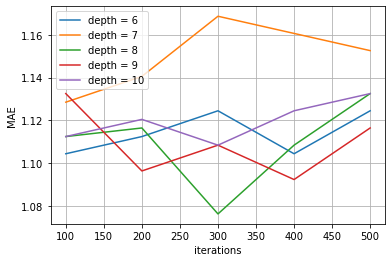

In [40]:
# Зависимость МАЕ от к-ва деревьев для различной их глубины
ax = res[res['depth'] == res['depth'].unique()[0]].plot(
    x='iterations', y='mae',label='depth = {}'.format(res['depth'].unique()[0])
    )
for depth in res['depth'].unique()[1:]:
    res[res['depth'] == depth].plot(x='iterations', y='mae', grid=True, 
                                    label='depth = {}'.format(depth), ax=ax)
plt.ylabel('MAE')
plt.show()

In [41]:
%%time

# К-во деревьев (iterations) и число разветвлений с учетом дисбаланса классов.
res = pd.DataFrame(columns=['depth', 'iterations', 'mae', 'std'])
i = 1  # Порядковый номер эксперимента (индекс датасета)
catboost_params = catboost_params_coll.copy()
catboost_params.update({'auto_class_weights': 'Balanced'})

for depth in range(6, 11):  # Диапазон числа разветвлений
    catboost_params['depth'] = depth
    print('depth:', depth)
    for iterations in range(250, 1501, 250):  # Диапазон к-ва деревьев
        mae, std = tune(X_cat_train, y_train, catboost_params, 
                        'iterations', iterations, random_state=43)

        res.loc[i, ['depth', 'iterations', 'mae', 'std']] = \
        depth, iterations, mae, std
        i += 1

depth: 6
iterations = 250: MAE = 1.289 ± 0.149
iterations = 500: MAE = 1.269 ± 0.183
iterations = 750: MAE = 1.261 ± 0.199
iterations = 1000: MAE = 1.237 ± 0.183
iterations = 1250: MAE = 1.237 ± 0.183
iterations = 1500: MAE = 1.245 ± 0.186
depth: 7
iterations = 250: MAE = 1.305 ± 0.095
iterations = 500: MAE = 1.205 ± 0.137
iterations = 750: MAE = 1.225 ± 0.151
iterations = 1000: MAE = 1.181 ± 0.145
iterations = 1250: MAE = 1.169 ± 0.137
iterations = 1500: MAE = 1.177 ± 0.143
depth: 8
iterations = 250: MAE = 1.249 ± 0.143
iterations = 500: MAE = 1.205 ± 0.165
iterations = 750: MAE = 1.225 ± 0.153
iterations = 1000: MAE = 1.209 ± 0.158
iterations = 1250: MAE = 1.217 ± 0.147
iterations = 1500: MAE = 1.201 ± 0.141
depth: 9
iterations = 250: MAE = 1.317 ± 0.136
iterations = 500: MAE = 1.221 ± 0.148
iterations = 750: MAE = 1.201 ± 0.134
iterations = 1000: MAE = 1.177 ± 0.121
iterations = 1250: MAE = 1.157 ± 0.123
iterations = 1500: MAE = 1.161 ± 0.133
depth: 10
iterations = 250: MAE = 1.281 

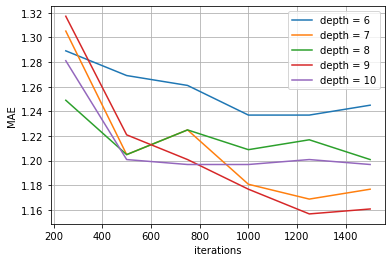

In [42]:
# Зависимость МАЕ от к-ва деревьев для различной их глубины с учетом дисбаланса классов
ax = res[res['depth'] == res['depth'].unique()[0]].plot(
    x='iterations', y='mae',label='depth = {}'.format(res['depth'].unique()[0])
    )
for depth in res['depth'].unique()[1:]:
    res[res['depth'] == depth].plot(x='iterations', y='mae', grid=True, 
                                    label='depth = {}'.format(depth), ax=ax)
plt.ylabel('MAE')
plt.show()

Попытка учета дисбаланса классов целевого признака явно не приносит положительного результата.

In [43]:
%%time

# Более подробный просмотр диапазона с минимальным значением МАЕ
catboost_params = catboost_params_coll.copy()
catboost_params['depth'] = 8
print('depth:', catboost_params['depth'])

for iterations in range(200, 401, 25):  # Диапазон к-ва деревьев
    mae, std = tune(X_cat_train, y_train, catboost_params, 
                    'iterations', iterations, random_state=43)

depth: 8
iterations = 200: MAE = 1.116 ± 0.093
iterations = 225: MAE = 1.112 ± 0.080
iterations = 250: MAE = 1.096 ± 0.090
iterations = 275: MAE = 1.096 ± 0.089
iterations = 300: MAE = 1.076 ± 0.113
iterations = 325: MAE = 1.068 ± 0.114
iterations = 350: MAE = 1.088 ± 0.128
iterations = 375: MAE = 1.100 ± 0.144
iterations = 400: MAE = 1.108 ± 0.153
CPU times: user 4min 24s, sys: 2min 49s, total: 7min 14s
Wall time: 4min 17s


In [46]:
# Фиксируем гиперпараметры с лучшей метрикой 
catboost_params_coll.update({'depth': 8, 'iterations': 325})

Подбор шага градиентного спуска:

In [47]:
%%time

# Датасет для фиксации значений метрики
res = pd.DataFrame(columns=['learning_rate', 'mae', 'std'])
i = 1  # Порядковый номер эксперимента (индекс датасета)
catboost_params = catboost_params_coll.copy()

print('catboost_params:', catboost_params)  # Зафиксированные гиперпараметры 
for learning_rate in [.001, .005, .01, .03, .05, .1, .5]:  # Диапазон шага
    mae, std = tune(X_cat_train, y_train, catboost_params, 
                  'learning_rate', learning_rate, random_state=43)

    res.loc[i, ['learning_rate', 'mae', 'std']] = learning_rate, mae, std
    i += 1

catboost_params: {'depth': 8, 'iterations': 325}
learning_rate = 0.001: MAE = 1.165 ± 0.073
learning_rate = 0.005: MAE = 1.161 ± 0.058
learning_rate = 0.01: MAE = 1.145 ± 0.100
learning_rate = 0.03: MAE = 1.068 ± 0.114
learning_rate = 0.05: MAE = 1.124 ± 0.119
learning_rate = 0.1: MAE = 1.149 ± 0.117
learning_rate = 0.5: MAE = 1.189 ± 0.115
CPU times: user 3min 40s, sys: 2min 23s, total: 6min 3s
Wall time: 3min 36s


Оставляем значение по умолчанию.

In [48]:
# Обучение модели с подобранными гиперпараметрами
catboost_default_params.update(catboost_params_coll)

learn_pool = Pool(
    X_cat_train, 
    y_train, 
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_cat_train)
)

model_30 = CatBoostClassifier(**catboost_default_params)
model_30.fit(learn_pool, verbose=False)

**2.2.2. Комбинация №23**  
- Прямое кодирование признаков: 'repository_name', 'commit_author', 'dayofweek';  
- Модель LinearRegression. 

In [49]:
# Обучение модели линейной регрессии
model_23 = LinearRegression()
model_23.fit(X_23_train, y_train)

LinearRegression()

### 3. Тестирование модели  


In [50]:
#  МАЕ константной модели (для проверки моделей на адекватность)
mean_absolute_error(y_test, 
                    pd.Series(round(y_train.median()), index=y_test.index))

1.203125

In [51]:
# МАЕ классификатора CatBoost
test_pool_30 = Pool(
    X_cat_test, 
    cat_features=['repository_name', 'commit_author', 'hour', 'dayofweek'],
    text_features=text_features,
    feature_names=list(X_cat_test)
)

mean_absolute_error(y_test, model_30.predict(test_pool_30))

0.796875

In [52]:
# МАЕ модели линейной регрессии 
mean_absolute_error(y_test, model_23.predict(X_23_test).round())

1.109375

Обе модели адекватны, т.е. имеют качество предсказания лучше, чем константной модели.

In [53]:
# Ансамбль моделей
prediction_30 = model_30.predict(X_cat_test)
prediction_30 = prediction_30.reshape((prediction_30.shape[0], ))

prediction_23 = model_23.predict(X_23_test).round()

prediction_ens = ((prediction_30 + prediction_23) / 2).round()

mean_absolute_error(y_test, prediction_ens)

0.859375

In [54]:
check = pd.DataFrame({'prediction': prediction_30.astype(int),
                      'target': y_test.values}, index=y_test.index)
check['error'] = check['prediction'] - check['target']
check.head()

,prediction,target,error
73,2,3,-1
218,1,1,0
25,3,3,0
208,4,3,1
9,4,5,-1


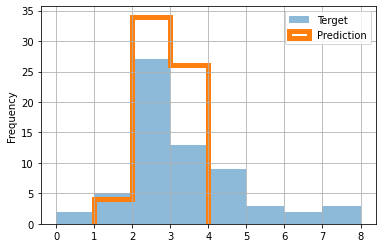

In [55]:
ax = check.plot(y='target', kind='hist', 
            bins=check['target'].max()-check['target'].min(),
            alpha=.5, label='Terget')

check.plot(y='prediction', kind='hist',
          bins=check['prediction'].max()-check['prediction'].min(),
          histtype='step', linewidth=5, label='Prediction', grid=True,
          ax=ax)
plt.show()

**Вывод**  
На основе предоставленного датасета реализована модель машинного обучения со средней абсолютной ошибкой на тестовой выборке 0,8. Данного результата удалось достигнуть алгоритму классификатора CatBoost, с учетом предобработки данных.  
Модель предсказывает только небольшое количество багов, до 4. БОльшие значения не имеют достаточного количетсва объектов для нормального обучения (как и коммиты с 0 багов). Попытка учесть дисбаланс классов приводит к снижению качетсва предсказания.